In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import dateutil.easter as easter
from lightgbm import LGBMRegressor
import lightgbm as lgb
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])

train.head()


,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [3]:
# min and max date
print("train min date:", train['date'].min())
print("train max date:", train['date'].max())
print("test min date:", test['date'].min())
print("test max date:", test['date'].max())

train min date: 2017-01-01 00:00:00
train max date: 2020-12-31 00:00:00
test min date: 2021-01-01 00:00:00
test max date: 2021-12-31 00:00:00


In [4]:
# # sales 
# train.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=True)
# plt.show()

There are six countries, two stores, and six products.

Plot of all combination of countries, stores, and products.

In [5]:
# tmp = train.groupby(['country','store','product'])
# # plot
# # showing only two plots
# plt.figure(figsize=(12,32))
# for i, (country, store, product) in enumerate(tmp.groups.keys()):
#     plt.subplot(len(tmp.groups.keys())//3, 3, i+1)
#     plt.plot(tmp.get_group((country, store, product))['date'], tmp.get_group((country, store, product))['num_sold'])
#     plt.title('{} - {} - {}'.format(country, store, product), fontsize=9)
#     plt.xticks(rotation=45)


    
# plt.subplots_adjust(hspace=1)
# plt.show()



Zooming in on the first country, store, and product sales

In [39]:
# tmp = train.groupby(['country','store','product'])
# # get first group
# country, store, product = list(tmp.groups.keys())[0]
# tmp = tmp.get_group((country, store, product))
# tmp = tmp.set_index('date')
# # plot daily sales

# tmp['num_sold']['2019-01-01':'2020-01-01'].plot()
# plt.title('{} - {} - {}'.format(country, store, product), fontsize=9)
# plt.xticks(rotation=45)
# plt.show()



In [40]:
# # december sales
# tmp['num_sold']['2019-12-01':'2020-01-01'].plot()
# plt.title('{} - {} - {}'.format(country, store, product), fontsize=9)
# plt.xticks(rotation=45)
# plt.show()

In [6]:
# # group by store
# plt.figure(figsize=(12,5))
# tmp = train.groupby(['store'])[["num_sold"]].mean()
# tmp.plot(kind='bar')
# plt.show() 

In [80]:
# # gruop by country
# plt.figure(figsize=(12,5))
# tmp = train.groupby(['country'])[["num_sold"]].mean()
# tmp.plot(kind='bar')
# plt.show()

Average sales in december

In [21]:
# # end of year
# plt.figure(figsize=(12,5))
# # month == 12 and month == 1
# tmp = train[train['date'].dt.month == 12]
# tmp = tmp.groupby(tmp.date.dt.day)['num_sold'].mean()
# tmp.plot(kind='bar', color='red', label='December', alpha=0.5)
# #
# tmp2 = train[train['date'].dt.month == 1]
# tmp2 = tmp2.groupby(tmp2.date.dt.day)['num_sold'].mean()
# tmp2.plot(kind='bar', color='blue', label='January', alpha=0.5)
# plt.legend()
# plt.show()

In [44]:
# # group by weekday
# tmp = train.groupby(train.date.dt.weekday)['num_sold'].mean()
# tmp.plot(kind='bar')

In [41]:
# # target distribution
# sns.histplot(train['num_sold'],kde=True)
# plt.show()

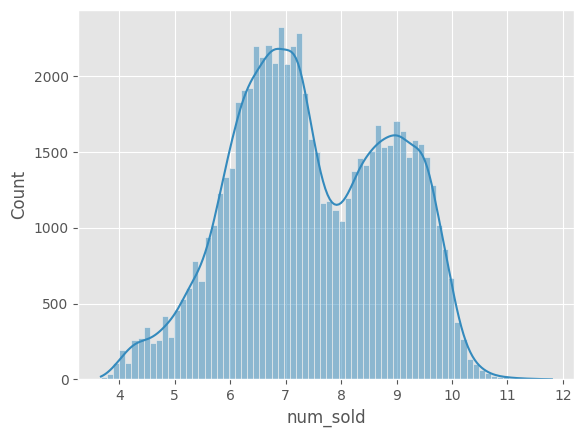

In [3]:
# box cox transformation 
from scipy.stats import boxcox

from scipy.special import inv_boxcox
train_data = train.copy()
train_data['num_sold'], lam = boxcox(train_data['num_sold'])
sns.histplot(train_data['num_sold'],kde=True)
plt.show()

Lightgbm baseline

In [31]:

def feature_encode(df):
    
    df['day'] = df['date'].dt.dayofyear
    # df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    # df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
 
    df["day_of_week"] = df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    df['day_of_year'] = df['date'].dt.dayofyear
    df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)

    df["important_dates"] = df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)

 
    # df['easter'] = df.date.isin(easter_date)
    for col in ['country','store','product']:
        df[col] = df[col].astype('category')

    return df
train_data = train.copy()

train_data['num_sold'], lam = boxcox(train_data['num_sold'])

train_data = feature_encode(train_data)
test_data = feature_encode(test)
features = [col for col in train_data.columns if col not in ['row_id','num_sold','date','month']]

In [5]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 200

In [28]:
%%time 
 # cross validation
import warnings
warnings.filterwarnings('ignore')
params =  {'n_estimators': 740, 'learning_rate': 0.02655381461800373, 'num_leaves': 94, 'colsample_bytree': 0.6632670829555092, 'subsample': 0.5382093069333321, 'reg_alpha': 0.4633422115536414, 'reg_lambda': 0.48815978811966815,'objective':'regression','metric':'mae',
          'random_state':42,'verbose':-1}
split = TimeSeriesSplit(n_splits=5)
avg_smape = 0
for train_index, test_index in split.split(train_data):
    train_data_split = train_data.iloc[train_index]
    test_data_split = train_data.iloc[test_index]
    y_train = train_data_split['num_sold']
    X_train = train_data_split[features]
    y_test = test_data_split['num_sold']
    X_test = test_data_split[features]
    train_dataset = lgb.Dataset(X_train, y_train, categorical_feature=['country','store','product'])
    test_dataset = lgb.Dataset(X_test, y_test,categorical_feature=['country','store','product'])
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],callbacks=[lgb.early_stopping(200),lgb.log_evaluation(0)])
    y_pred = model.predict(X_test)
    y_pred = inv_boxcox(y_pred, lam)
    avg_smape += smape(inv_boxcox(y_test, lam), y_pred)

print('avg smape:', avg_smape / split.n_splits)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	valid_0's l1: 0.227354
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[328]	valid_0's l1: 0.206109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[241]	valid_0's l1: 0.106306
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 0.370171
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 0.59379
avg smape: 14.215830621804518
CPU times: user 29.4 s, sys: 834 ms, total: 30.2 s
Wall time: 8.14 s


In [32]:
# train in full data
y_train = train_data['num_sold']
X_train = train_data[features]
model = LGBMRegressor(**params)
model.fit(X_train, y_train)
y_pred = model.predict(test_data[features])
y_pred = inv_boxcox(y_pred, lam)
# rounding
y_pred = np.round(y_pred)


In [ ]:
tmp = train.groupby(['country','store','product'])
# get first group
country, store, product = list(tmp.groups.keys())[0]
tmp = tmp.get_group((country, store, product))
tmp = feature_encode(tmp)
pred = model.predict(tmp[features])
pred = inv_boxcox(pred, lam)


(array([17167., 17348., 17532., 17713., 17897., 18078., 18262., 18444.,
        18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

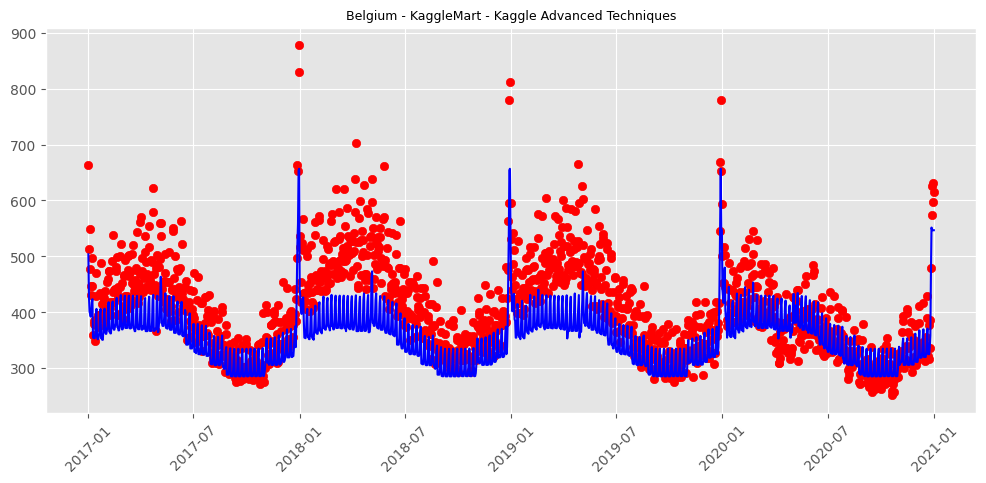

In [30]:
plt.figure(figsize=(12,5))
plt.scatter(tmp['date'], tmp['num_sold'], label='actual', color='red')
plt.plot(tmp['date'], pred, label='prediction', color='blue')
plt.title('{} - {} - {}'.format(country, store, product), fontsize=9)
plt.xticks(rotation=45)

In [10]:
# catboost
params = {'n_estimators': 835, 'learning_rate': 0.08071991964057122, 'depth': 5, 'l2_leaf_reg': 4, 'subsample': 0.9955859992357842, 'random_state': 42}
# time series split
split = TimeSeriesSplit(n_splits=5)
avg_smape = 0
pred = np.zeros(test_data.shape[0])
for train_index, test_index in split.split(train_data):
    train_data_split = train_data.iloc[train_index]
    test_data_split = train_data.iloc[test_index]
    y_train = train_data_split['num_sold']
    X_train = train_data_split[features]
    y_test = test_data_split['num_sold']
    X_test = test_data_split[features]
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,cat_features=['country','store','product'],verbose=0)
    y_pred = model.predict(X_test)
    y_pred = inv_boxcox(y_pred, lam)
    avg_smape += smape(inv_boxcox(y_test, lam), y_pred)
    pred +model.predict(test_data[features])
# rounding
pred = np.round(pred)/split.n_splits
print('avg smape:', avg_smape / split.n_splits)

KeyboardInterrupt: 

In [70]:
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'objective': 'regression',
        'metric': 'mae',
        'random_state': 42
    }
    split = TimeSeriesSplit(n_splits=5)
    avg_smape = 0
    for train_index, test_index in split.split(train_data):
        train_data_split = train_data.iloc[train_index]
        test_data_split = train_data.iloc[test_index]
        y_train = train_data_split['num_sold']
        X_train = train_data_split[features]
        y_test = test_data_split['num_sold']
        X_test = test_data_split[features]
        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = inv_boxcox(y_pred, lam)
        avg_smape += smape(inv_boxcox(y_test, lam), y_pred)
    return avg_smape / split.n_splits
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study()
study.optimize(objective, n_trials=50)
# save to file log
study.trials_dataframe().to_csv('log.csv')
print('best params:', study.best_params)

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


best params: {'n_estimators': 740, 'learning_rate': 0.02655381461800373, 'num_leaves': 94, 'colsample_bytree': 0.6632670829555092, 'subsample': 0.5382093069333321, 'reg_alpha': 0.4633422115536414, 'reg_lambda': 0.48815978811966815}


In [19]:
def objective(trial):
    print('trial:', trial.number)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 10),
        
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'random_state': 42
    }
    split = TimeSeriesSplit(n_splits=5)
    avg_smape = 0
    for train_index, test_index in split.split(train_data):
        train_data_split = train_data.iloc[train_index]
        test_data_split = train_data.iloc[test_index]
        y_train = train_data_split['num_sold']
        X_train = train_data_split[features]
        y_test = test_data_split['num_sold']
        X_test = test_data_split[features]
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train,cat_features=['country','store','product'],verbose=0)
        y_pred = model.predict(X_test)
        y_pred = inv_boxcox(y_pred, lam)
        avg_smape += smape(inv_boxcox(y_test, lam), y_pred)
    return avg_smape / split.n_splits
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study()
study.optimize(objective, n_trials=25)


trial: 0
trial: 1
trial: 2
trial: 3
trial: 4
trial: 5
trial: 6
trial: 7
trial: 8
trial: 9
trial: 10
trial: 11
trial: 12
trial: 13
trial: 14
trial: 15
trial: 16
trial: 17
trial: 18
trial: 19
trial: 20
trial: 21
trial: 22
trial: 23
trial: 24


In [20]:
print('best params:', study.best_params)

best params: {'n_estimators': 835, 'learning_rate': 0.08071991964057122, 'depth': 5, 'l2_leaf_reg': 4, 'subsample': 0.9955859992357842}


In [16]:
submission = pd.DataFrame({'row_id':test_data['row_id'],'num_sold':y_pred})
submission.to_csv('submission.csv', index=False)


In [17]:
import os
COMPETITION = 'tabular-playground-series-sep-2022'
MESSAGE = 'LGBMRegressor'
os.system('kaggle competitions submit -c {} -f submission.csv -m "{}"'.format(COMPETITION, MESSAGE))

100%|███████████████████████████████████████| 201k/201k [00:00<00:00, 309kB/s]


Successfully submitted to Tabular Playground Series - Sep 2022

0

In [18]:
# check leaderboard
os.system('kaggle competitions submissions -c {}'.format(COMPETITION))

fileName        date                 description                    status    publicScore  privateScore  
--------------  -------------------  -----------------------------  --------  -----------  ------------  
submission.csv  2022-09-10 12:03:03  LGBMRegressor                  complete  22.22151                   
submission.csv  2022-09-04 04:05:14  LGBMRegressor                  complete  7.08715                    
submission.csv  2022-09-04 04:03:47  LGBMRegressor                  complete  7.08715                    
submission.csv  2022-09-03 04:22:47  LGBMRegressor                  complete  6.81606                    
lightgbm        2022-09-03 02:49:59  Notebook lightgbm | Version 3  complete  6.31193                    
submission.csv  2022-09-03 02:44:50  LGBMRegressor                  complete  6.31193                    
submission.csv  2022-09-03 02:19:03  LGBMRegressor                  complete  6.43603                    
submission.csv  2022-09-02 02:36:43  LGBMRegre

0